Found 1463 files belonging to 3 classes.
Found 151 files belonging to 3 classes.
Class Names: ['Benign', 'Malignant', 'No Tumor']
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 5923155 (22.60 MB)
Trainable params: 3843 

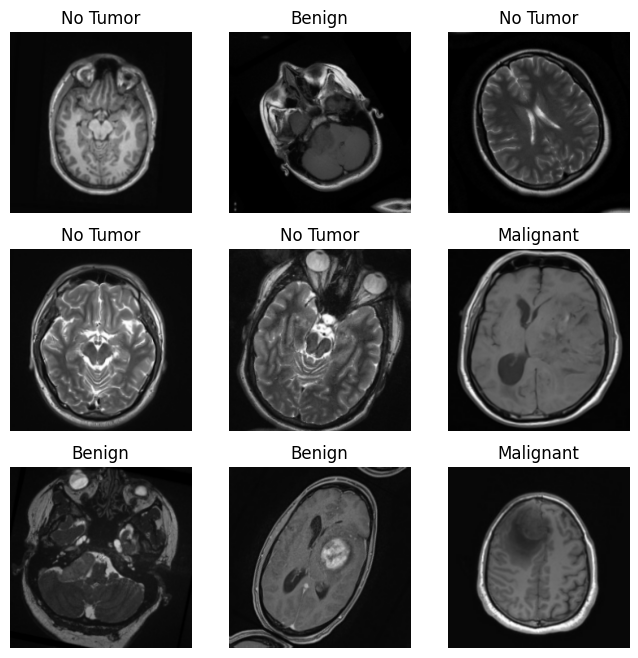

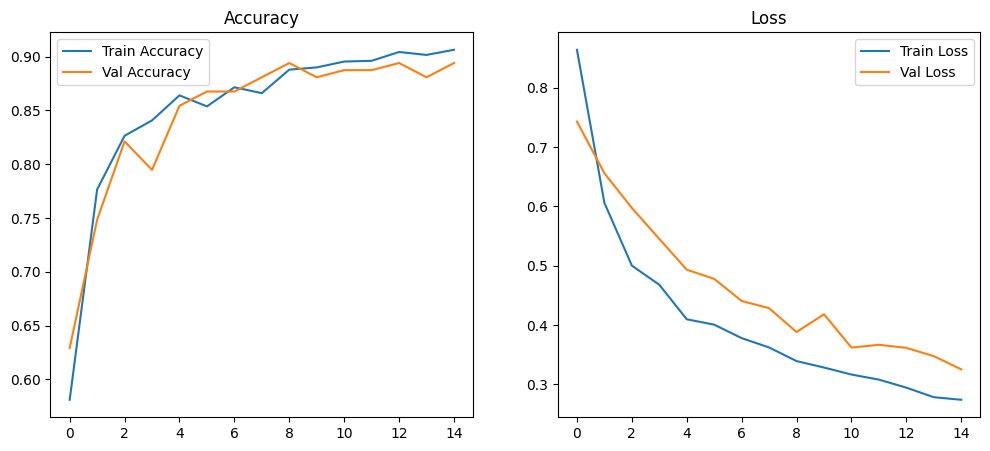

1/1 [==============================] - 2s 2s/step


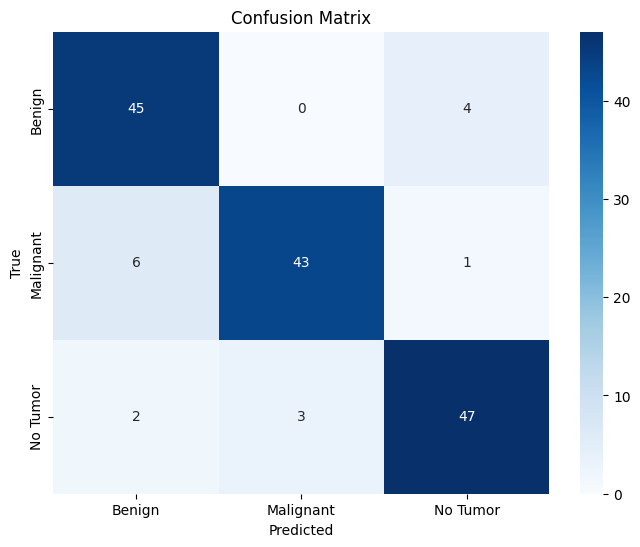


Classification Report:

              precision    recall  f1-score   support

      Benign       0.85      0.92      0.88        49
   Malignant       0.93      0.86      0.90        50
    No Tumor       0.90      0.90      0.90        52

    accuracy                           0.89       151
   macro avg       0.90      0.89      0.89       151
weighted avg       0.90      0.89      0.89       151



C:\Users\python main\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model saved as softtissuetumor.h5


In [1]:

# ================================
# 1. Import Required Libraries
# ================================
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

# ================================
# 2. Load Dataset (Train / Validation)
# ================================
train_dir = "datasetfin/train"   # <-- Change path to your train folder
val_dir = "datasetfin/val"       # <-- Change path to your validation folder

img_size = (224, 224)   # EfficientNetV2 default
batch_size = 32

train_ds = image_dataset_from_directory(
    train_dir,
    validation_split=None,
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

val_ds = image_dataset_from_directory(
    val_dir,
    validation_split=None,
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode="categorical"
)

class_names = train_ds.class_names
print("Class Names:", class_names)

# ================================
# 3. Data Preprocessing / Augmentation
# ================================
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# ================================
# 4. Visualize Sample Images
# ================================
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

# ================================
# 5. Build EfficientNetV2 Model
# ================================
base_model = keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape=img_size + (3,)
)
base_model.trainable = False  # Freeze base model for transfer learning

model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation="softmax")
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ================================
# 6. Train Model
# ================================
epochs = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# ================================
# 7. Training Graphs
# ================================
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title("Loss")
plt.show()

# ================================
# 8. Evaluation - Confusion Matrix
# ================================
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# ================================
# 9. Save Model
# ================================
model.save("newsofttissuetumor.h5")
print("Model saved as softtissuetumor.h5")
